In [1]:
import torch;print(torch.__name__, torch.__version__)
import torchvision;print(torchvision.__name__, torchvision.__version__)
import albumentations as A;print(A.__version__)
import torchvision.transforms as transforms
import cv2;print(cv2.__name__, cv2.__version__)

torch 2.0.1+cu118
torchvision 0.15.2+cu118
1.3.0
cv2 4.7.0


In [2]:
# Compose : tensorflow, torch의 torchvision 과 같은 효과

# ToTensor
# Convert a PIL Image or ndarray to tensor and scale the values accordingly.
# numpy.ndarray (H x W x C) range[0, 255] -> Tensor (C x H x W) range [0.0, 1.0] 

# Normalize
# 보통은 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))를 사용
# 혹은 직접 평균, 편차를 구하여 계산
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()
    
    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)
# 0.5를 뺀 뒤 0.5로 나누어 정규화

transform = transfroms.Compose(
    [transfroms.ToTensor(), # 0~1의 범위를 가지도록 정규화
    transfroms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] # -1~1의 범위를 가지도록 정규화 (standard)
)

BATCH_SIZE = 4

trainset = torchvision.datasets.CIFAR10(root="../data/ex17", train=True,download=True,transform=transform)
testset = torchvision.datasets.CIFAR10(root="../data/ex17", train=False,download=True,transform=transform)

# tensorflow의 dataset 개념과 비슷?
# num_workers의 default는 0인데 왜 2로 세팅하는지 check
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
for image, label in trainset:
    print(image.size())
    print(type(label))
    break

torch.Size([3, 32, 32])
<class 'int'>


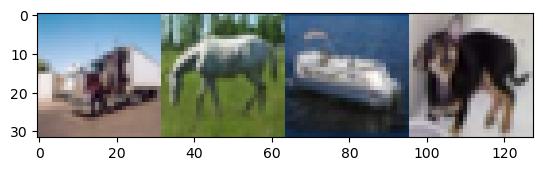

truck horse ship  dog  


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    img = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()
    
data_iter = iter(trainloader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images, padding=0))

print(' '.join(f"{classes[labels[j]]:5s}" for j in range(BATCH_SIZE)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Conv2d class
# Conv2d(in_channels, out_channels, kernel_size,
#        stride=1, padding=0, dilation=1,groups=1,
#        bias=True, padding_mode='zeros', device=None, dtype=None)


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5) # input_ch 3 -> output_ch 6, 32->28
        self.pool = nn.MaxPool2d(2, 2) # kernel_size, stride=None, padding=0, 28->14
        self.conv2 = nn.Conv2d(6,16,5) # 14->10
        self.fc1 = nn.Linear(16*5*5, 120) # input, output
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1) # flatten에 1 dim은 Batch dim
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
net = net.to("cuda")
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to("cuda")
optimizer = optim.Adam(net.parameters()) # optmizizer 안에 network의 parameters를 넣어둠

In [9]:
EPOCHS = 10
for epoch in range(EPOCHS):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        
        # optimizer 안의 grad를 초기화
        optimizer.zero_grad()
        
        # forward
        outputs = net(inputs) # last activation 없음
        
        # loss
        loss = criterion(outputs, labels)
        
        # calc gard
        loss.backward()
        
        # backpropagation
        optimizer.step()
        
        # show
        running_loss += loss.item() # 로스값 추가
        if i % 2000 == 1999:
            print(f"[{epoch+1:2d}/{EPOCHS}, iter:{i+1:5d}], loss:{running_loss/2000:.6f}")
            running_loss = 0.0
print("End")

[ 1/10, iter: 2000], loss:1.847118
[ 1/10, iter: 4000], loss:1.600050
[ 1/10, iter: 6000], loss:1.520403
[ 1/10, iter: 8000], loss:1.476971
[ 1/10, iter:10000], loss:1.415346
[ 1/10, iter:12000], loss:1.425233
[ 2/10, iter: 2000], loss:1.320944
[ 2/10, iter: 4000], loss:1.328698
[ 2/10, iter: 6000], loss:1.269762
[ 2/10, iter: 8000], loss:1.273867
[ 2/10, iter:10000], loss:1.262446
[ 2/10, iter:12000], loss:1.265712
[ 3/10, iter: 2000], loss:1.183898
[ 3/10, iter: 4000], loss:1.186927
[ 3/10, iter: 6000], loss:1.168963
[ 3/10, iter: 8000], loss:1.182764
[ 3/10, iter:10000], loss:1.190131
[ 3/10, iter:12000], loss:1.172009
[ 4/10, iter: 2000], loss:1.083626
[ 4/10, iter: 4000], loss:1.107531
[ 4/10, iter: 6000], loss:1.098130
[ 4/10, iter: 8000], loss:1.109631
[ 4/10, iter:10000], loss:1.134142
[ 4/10, iter:12000], loss:1.093592
[ 5/10, iter: 2000], loss:1.043057
[ 5/10, iter: 4000], loss:1.041453
[ 5/10, iter: 6000], loss:1.037375
[ 5/10, iter: 8000], loss:1.057973
[ 5/10, iter:10000],

In [31]:
os.mkdir("train_sample")

In [32]:
# save model
PATH = 'train_sample/cifar_net.pth'
torch.save(net.state_dict(), PATH) # 가중치만?, 통째로?

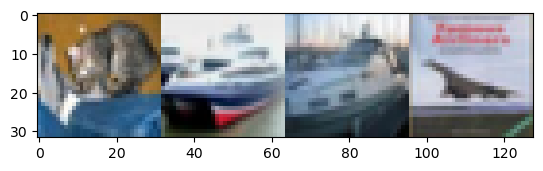

GroundTruth:  cat   ship  ship  plane


<All keys matched successfully>

In [33]:
# test
data_iter = iter(testloader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images, padding=0))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH)) # 가중치만 가져오는 save

In [34]:
outputs = net(images)
outputs

tensor([[ -6.0908,  -7.9045,  -2.8587,   1.7719,  -3.8318,  -0.2172,  -1.7282,
          -4.0815,  -6.6338,  -6.2928],
        [ -5.8367,  -1.6055, -15.6593, -18.8138, -18.4160, -22.7295, -20.4771,
         -25.5356,  -3.8893,  -8.0697],
        [ -2.3581,   0.2124,  -5.2556,  -6.0454,  -5.3960,  -7.1415,  -7.4206,
          -7.1199,  -0.2649,  -1.2072],
        [  0.5378,  -4.5250,  -2.7709,  -6.4537,  -4.2079,  -7.7793,  -7.2232,
          -7.7823,  -0.5120,  -5.9123]], grad_fn=<AddmmBackward0>)

In [35]:
torch.max(outputs, 1) # torch.max는 값과 위치를 반환, max, argmax

torch.return_types.max(
values=tensor([ 1.7719, -1.6055,  0.2124,  0.5378], grad_fn=<MaxBackward0>),
indices=tensor([3, 1, 1, 0]))

In [36]:
_, predict = torch.max(outputs, 1)

print("predicted: ", " ".join(f"{classes[predict[j]]:5s}"for j in range(4)))

predicted:  cat   car   car   plane


In [44]:
# test metric

correct = 0
total = 0

# no grad calc
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item() # tensor값을 벗어날때 .item() 이용
        
print(100*correct//total)

60


In [46]:
# acc per class
correct = {classname:0 for classname in classes}
total = {classname:0 for classname in classes}

with torch.no_grad():
    
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        for label, pred in zip(labels, predicted):
            if label==pred:
                correct[classes[label]]+=1
            total[classes[label]]+=1

for classname, count in correct.items():
    acc = 100.0*count/total[classname]
    print(f'{classname:5s} is {acc:.3f}')

plane is 59.300
car   is 76.600
bird  is 30.000
cat   is 37.000
deer  is 61.600
dog   is 52.500
frog  is 69.800
horse is 73.600
ship  is 70.700
truck is 75.100


In [51]:
# train with gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(device)
device

cuda:0


device(type='cuda', index=0)

In [54]:
# 모델을 device에 지정
net.to(device) # 그냥 model.cuda() 해도 된다.

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [56]:
from torchsummary import summary

summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [70]:
image, label = data
print(image.size(), label.size()) # torch는 shape을 찍을때 .size() 를 사용
image

torch.Size([4, 3, 32, 32]) torch.Size([4])


tensor([[[[-0.3647, -0.2863, -0.2314,  ..., -0.3569, -0.3333, -0.2627],
          [-0.3255, -0.2235, -0.1686,  ..., -0.1529, -0.0980, -0.0431],
          [-0.2392, -0.1843, -0.1373,  ..., -0.3412, -0.1451, -0.0196],
          ...,
          [ 0.2784,  0.2863,  0.0902,  ...,  0.1765,  0.0980,  0.1686],
          [ 0.2549,  0.3333,  0.1373,  ...,  0.2549,  0.1922, -0.0745],
          [-0.0588, -0.0902,  0.0667,  ...,  0.2157,  0.3412,  0.3098]],

         [[-0.5529, -0.4588, -0.4118,  ..., -0.2627, -0.2706, -0.2784],
          [-0.4824, -0.4353, -0.3569,  ..., -0.2471, -0.2549, -0.2549],
          [-0.4275, -0.3804, -0.3490,  ..., -0.2627, -0.2549, -0.2392],
          ...,
          [ 0.3961,  0.2471,  0.0431,  ...,  0.0980, -0.0353,  0.1686],
          [ 0.5373,  0.4824,  0.0824,  ...,  0.2706,  0.1843,  0.0118],
          [ 0.3020,  0.1922,  0.2941,  ...,  0.0902,  0.3098,  0.2863]],

         [[-0.6627, -0.5843, -0.5059,  ..., -0.0902, -0.1137, -0.2000],
          [-0.5765, -0.5451, -

In [71]:
# gpu를 사용할 때 model 뿐아니라 data도 넣어줘야함
image, label = data[0].to(device), data[1].to(device)
image

tensor([[[[-0.3647, -0.2863, -0.2314,  ..., -0.3569, -0.3333, -0.2627],
          [-0.3255, -0.2235, -0.1686,  ..., -0.1529, -0.0980, -0.0431],
          [-0.2392, -0.1843, -0.1373,  ..., -0.3412, -0.1451, -0.0196],
          ...,
          [ 0.2784,  0.2863,  0.0902,  ...,  0.1765,  0.0980,  0.1686],
          [ 0.2549,  0.3333,  0.1373,  ...,  0.2549,  0.1922, -0.0745],
          [-0.0588, -0.0902,  0.0667,  ...,  0.2157,  0.3412,  0.3098]],

         [[-0.5529, -0.4588, -0.4118,  ..., -0.2627, -0.2706, -0.2784],
          [-0.4824, -0.4353, -0.3569,  ..., -0.2471, -0.2549, -0.2549],
          [-0.4275, -0.3804, -0.3490,  ..., -0.2627, -0.2549, -0.2392],
          ...,
          [ 0.3961,  0.2471,  0.0431,  ...,  0.0980, -0.0353,  0.1686],
          [ 0.5373,  0.4824,  0.0824,  ...,  0.2706,  0.1843,  0.0118],
          [ 0.3020,  0.1922,  0.2941,  ...,  0.0902,  0.3098,  0.2863]],

         [[-0.6627, -0.5843, -0.5059,  ..., -0.0902, -0.1137, -0.2000],
          [-0.5765, -0.5451, -

In [14]:
a = [1,2,3,4,5]
b = [1,2,3,4,5]

c = list(zip(a,b))
c

[(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]

In [17]:
d = [*a,*b]
d

[1, 2, 3, 4, 5, 1, 2, 3, 4, 5]